In [2]:
# libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.svm import LinearSVC, SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier


from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

import pickle

In [3]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [4]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [5]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [22]:
TM1 = pd.read_csv('Titanic/Results/AdaBoost/2-titanic-top-4-with-ensemble-modeling.csv')
TM2 = pd.read_csv('Titanic/Results/AdaBoost/3-eda-to-prediction-dietanic.csv')
TM3 = pd.read_csv('Titanic/Results/AdaBoost/4-a-statistical-analysis-ml-workflow-of-titanic.csv')
#TM4 = pd.read_csv('Titanic/Results/AdaBoost/4-stacked-classifier-top-10-on-lb.csv')
#TM5 = pd.read_csv('Titanic/Results/AdaBoost/5-ultimate-titanic-guide-for-beginners.csv')
TM6 = pd.read_csv('Titanic/Results/AdaBoost\\10-a-comprehensive-guide-to-titanic-machine-learning.csv')

from sklearn.neural_network import MLPClassifier
from sklearn.svm import NuSVC, SVC

In [29]:
TM1

,Unnamed: 0,classifier,T0,T1
0,accuracy,0.807547,0.769811,0.807547
1,f1,0.715084,0.702439,0.715084
2,statistical_parity_difference,-0.615574,-0.600038,-0.615574
3,equal_opportunity_difference,-0.448413,-0.317460,-0.448413
4,average_abs_odds_difference,0.439960,0.419249,0.439960
5,disparate_impact,-1.808366,-1.302122,-1.808366
6,theil_index,0.138374,0.118937,0.138374


In [6]:
import pandas as pd
import os
import glob


# use glob to get all the csv files 
# in the folder
TM_dict = dict()
paths = ["Titanic\\Results\\AdaBoost\\", "Titanic\\Results\\GBC\\", "Titanic\\Results\\XGBoost\\"]
for path in paths:
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    for f in csv_files:
        TM_dict[f] = pd.read_csv(f)
    
AC_dict = dict()    
paths = ["AdultNotebook\\Results\\AdaBoost\\", "AdultNotebook\\Results\\GBC\\", "AdultNotebook\\Results\\XGBoost\\"]
for path in paths:
    csv_files = glob.glob(os.path.join(path, "*.csv"))

    for f in csv_files:
        AC_dict[f] = pd.read_csv(f)

BM_dict = dict()
paths = ["BankMarketingNotebook\\Results\\AdaBoost\\", "BankMarketingNotebook\\Results\\GBC\\", "BankMarketingNotebook\\Results\\XGBoost\\"]
for path in paths:
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    for f in csv_files:
        BM_dict[f] = pd.read_csv(f)
    
GC_dict = dict()
paths = ["GermanCredit\\Results\\AdaBoost\\", "GermanCredit\\Results\\GBC\\", "GermanCredit\\Results\\XGBoost\\"]
for path in paths:
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    for f in csv_files:
        GC_dict[f] = pd.read_csv(f)
    
    
models = [TM_dict, AC_dict, BM_dict, GC_dict]

In [19]:
TM_dict.keys()
abc = 'Titanic\\Results\\AdaBoost\\10-a-comprehensive-guide-to-titanic-machine-learning.csv'
ad = abc.split("\\")
ad[2]

'AdaBoost'

# Titanic

Titanic\Results\AdaBoost\10-a-comprehensive-guide-to-titanic-machine-learning.csv
Titanic\Results\AdaBoost\2-titanic-top-4-with-ensemble-modeling.csv
Titanic\Results\AdaBoost\3-eda-to-prediction-dietanic.csv
Titanic\Results\AdaBoost\4-a-statistical-analysis-ml-workflow-of-titanic.csv
Titanic\Results\AdaBoost\6-titanic-best-working-classifier.csv
Titanic\Results\AdaBoost\7-titanic-survival-prediction-end-to-end-ml-pipeline.csv
Titanic\Results\GBC\0-introduction-to-ensembling-stacking-in-python.csv
Titanic\Results\GBC\1-a-data-science-framework-to-achieve-99-accuracy.csv
Titanic\Results\GBC\2-titanic-top-4-with-ensemble-modeling.csv
Titanic\Results\GBC\3-eda-to-prediction-dietanic.csv
Titanic\Results\GBC\4-a-statistical-analysis-ml-workflow-of-titanic.csv
Titanic\Results\GBC\6-titanic-best-working-classifier.csv
Titanic\Results\XGBoost\0-introduction-to-ensembling-stacking-in-python.csv
Titanic\Results\XGBoost\2-eda-to-prediction-dietanic.csv
Titanic\Results\XGBoost\3-a-statistical-analy

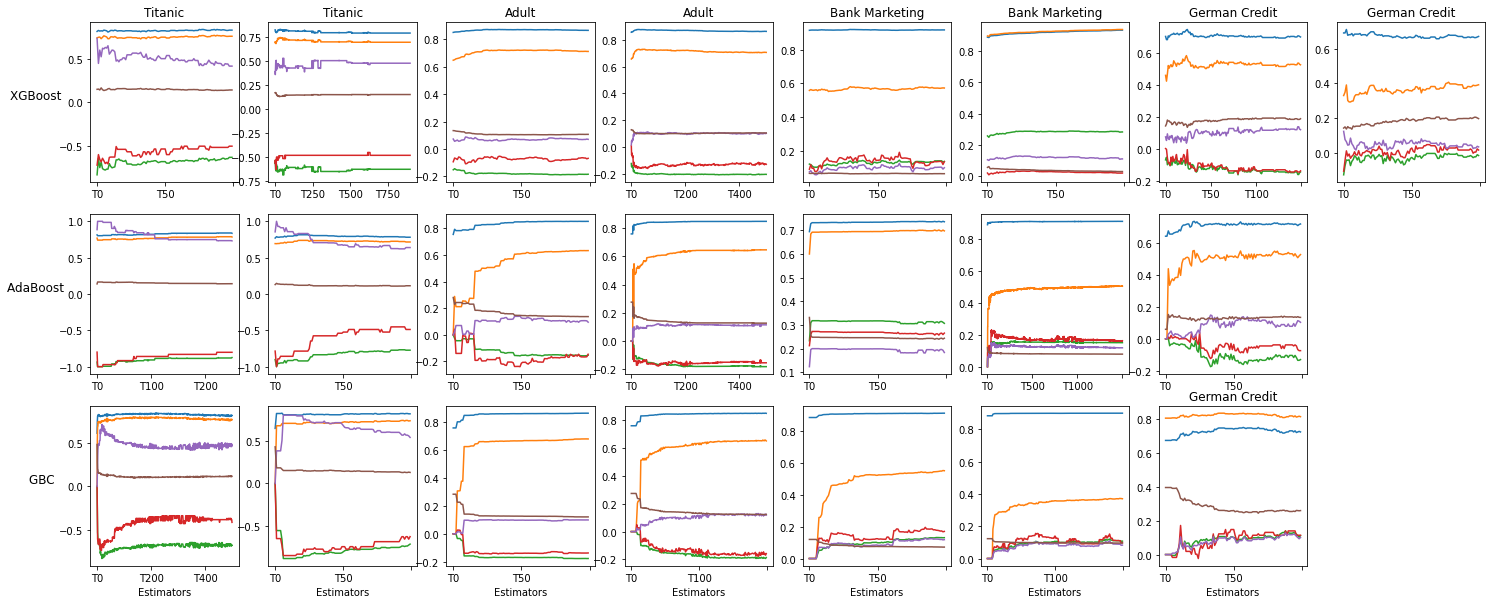

In [10]:
figure, axis = plt.subplots(3, 8, figsize=(25,10))
ncols = 0
nrows = 0

for df in TM_dict.keys():
    print(df)
    if df.split("\\")[2] == 'XGBoost':
        model = TM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 0 or ncols ==1:
            temp = model.T.plot(ax=axis[0,ncols], legend=0)
        if ncols == 0:
            temp.set_ylabel('XGBoost          ', rotation=0, size='large')    
        temp.title.set_text('Titanic')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
            
    if df.split("\\")[2] == 'AdaBoost':
        model = TM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 0 or ncols ==1:
            temp = model.T.plot(ax=axis[1,ncols], legend=0)
        if ncols == 0:
            temp.set_ylabel('AdaBoost          ', rotation=0, size='large')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
            
    if df.split("\\")[2] == 'GBC':
        model = TM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 0 or ncols ==1:
            temp = model.T.plot(ax=axis[2,ncols], legend=0)
        if ncols == 0:
            temp.set_ylabel('GBC       ', rotation=0, size='large')    
        temp.set_xlabel('Estimators')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0

ncols = 0
nrows = 0

for df in AC_dict.keys():

    if df.split("\\")[2] == 'XGBoost':

        model = AC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 0:
            temp = model.T.plot(ax=axis[0,2], legend=0)
        if ncols == 1:
            temp = model.T.plot(ax=axis[0,3], legend=0)
        temp.title.set_text('Adult')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
 
    if df.split("\\")[2] == 'AdaBoost':
        model = AC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 0:
            temp = model.T.plot(ax=axis[1,2], legend=0)
        if ncols == 3:
            temp = model.T.plot(ax=axis[1,3], legend=0)

        ncols = ncols+1
        if ncols == 6:
            ncols = 0
            
    if df.split("\\")[2] == 'GBC':
        model = AC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 0:
            temp = model.T.plot(ax=axis[2,2], legend=0)
        if ncols == 3:
            temp = model.T.plot(ax=axis[2,3], legend=0)
        temp.set_xlabel('Estimators')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
            
ncols = 0
nrows = 0

for df in BM_dict.keys():
    print(df)
    if df.split("\\")[2] == 'XGBoost':

        model = BM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 0:
            temp = model.T.plot(ax=axis[0,4], legend=0)
        if ncols == 3:
            temp = model.T.plot(ax=axis[0,5], legend=0)
        temp.title.set_text('Bank Marketing')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
 
    if df.split("\\")[2] == 'AdaBoost':
        model = BM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 1:
            temp = model.T.plot(ax=axis[1,4], legend=0)
        if ncols == 2:
            temp = model.T.plot(ax=axis[1,5], legend=0)
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
            
    if df.split("\\")[2] == 'GBC':
        model = BM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 0:
            temp = model.T.plot(ax=axis[2,4], legend=0)
        if ncols == 1:
            temp = model.T.plot(ax=axis[2,5], legend=0)
        temp.set_xlabel('Estimators')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0

ncols = 0
nrows = 0

for df in GC_dict.keys():
    print(df)
    if df.split("\\")[2] == 'XGBoost':

        model = GC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 0:
            temp = model.T.plot(ax=axis[0,6], legend=0)
        if ncols == 3:
            temp = model.T.plot(ax=axis[0,7], legend=0)
        temp.title.set_text('German Credit')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
 
    if df.split("\\")[2] == 'AdaBoost':
        model = GC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 0:
            temp = model.T.plot(ax=axis[1,6], legend=0)
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
            
    if df.split("\\")[2] == 'GBC':
        model = GC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        if ncols == 1:
            temp = model.T.plot(ax=axis[2,6], legend=0)
        temp.set_xlabel('Estimators')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0



#plt.legend(handles=[l, l2, l3, l4],loc="upper left", bbox_to_anchor=[0, 1],
#ncol=2, shadow=True, title="Legend", fancybox=True)
#handles, labels = temp.get_legend_handles_labels()
#temp.legend(handles, labels, loc='upper center')
figure.delaxes(axis[1][7])
figure.delaxes(axis[2][7])

#temp.legend(loc='best', bbox_to_anchor=(2.4, -0.5))
plt.savefig('Boosting_Estimators.pdf', bbox_inches='tight')
plt.show()

In [ ]:
Final_dict = {}



## Adult

##### GBC

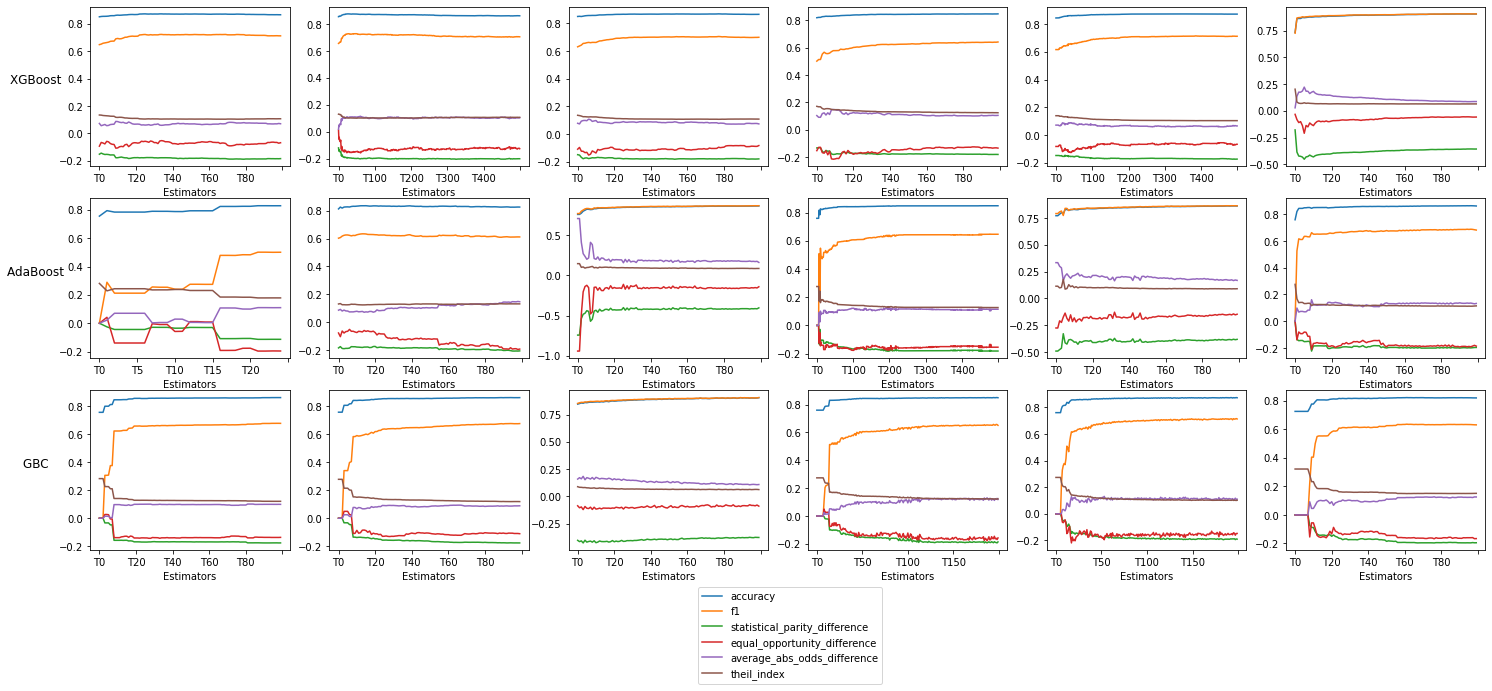

In [9]:
figure, axis = plt.subplots(3, 6, figsize=(25,10))
ncols = 0
nrows = 0

for df in AC_dict.keys():

    if df.split("\\")[2] == 'XGBoost':

        model = AC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        temp = model.T.plot(ax=axis[0,ncols], legend=0)
        if ncols == 0:
            temp.set_ylabel('XGBoost          ', rotation=0, size='large')    
        temp.set_xlabel('Estimators')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
 
    if df.split("\\")[2] == 'AdaBoost':
        model = AC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        temp = model.T.plot(ax=axis[1,ncols], legend=0)
        if ncols == 0:
            temp.set_ylabel('AdaBoost          ', rotation=0, size='large')    
        temp.set_xlabel('Estimators')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
            
    if df.split("\\")[2] == 'GBC':
        model = AC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        temp = model.T.plot(ax=axis[2,ncols], legend=0)
        if ncols == 0:
            temp.set_ylabel('GBC          ', rotation=0, size='large')    
        temp.set_xlabel('Estimators')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
            
temp.legend(loc='best', bbox_to_anchor=(-2, -2.6))
plt.savefig('Adult_Boosting_Estimators.pdf', bbox_inches='tight')
plt.show()

## Bank Marketing

##### GBC

BankMarketingNotebook\Results\AdaBoost\0-ensemble-techniques.csv
BankMarketingNotebook\Results\AdaBoost\2-bank-marketing-imbalanced-classes-resampling.csv
BankMarketingNotebook\Results\AdaBoost\3-classification-svm-decision-trees-boosting.csv
BankMarketingNotebook\Results\AdaBoost\4-subscription-predictor.csv
BankMarketingNotebook\Results\AdaBoost\5-machine-learning-algos.csv
BankMarketingNotebook\Results\AdaBoost\6-ensemble-techniques (1).csv
BankMarketingNotebook\Results\GBC\0-bank-marketing-classification-roc-f1-recall.csv
BankMarketingNotebook\Results\GBC\1-ensemble-techniques.csv
BankMarketingNotebook\Results\GBC\2-waba-laba-dubb-dubb.csv
BankMarketingNotebook\Results\GBC\5-bank-marketing-imbalanced-classes-resampling.csv
BankMarketingNotebook\Results\GBC\7-classification-svm-decision-trees-boosting.csv
BankMarketingNotebook\Results\GBC\8-classification-problem-practice-from-best-notebook.csv
BankMarketingNotebook\Results\XGBoost\0-bank-marketing-classification-roc-f1-recall.csv
B

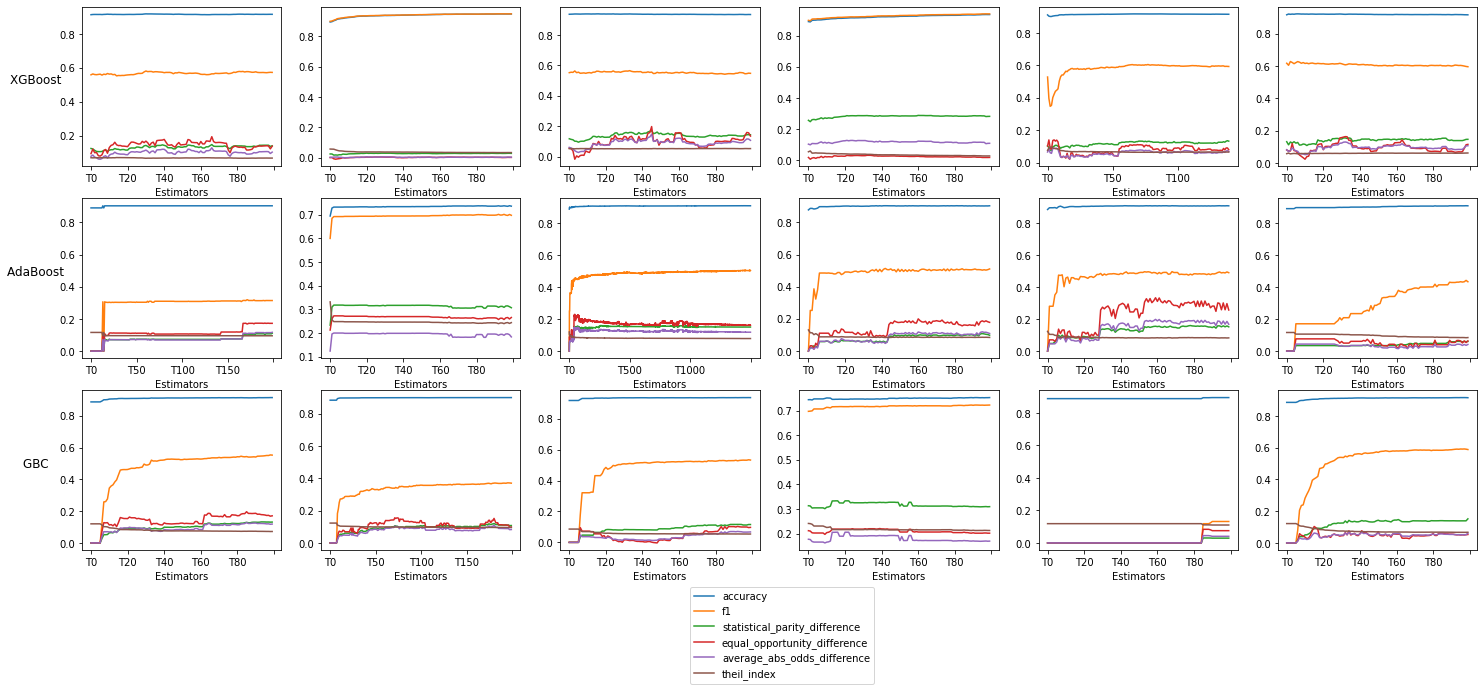

In [122]:
figure, axis = plt.subplots(3, 6, figsize=(25,10))
ncols = 0
nrows = 0

for df in BM_dict.keys():
    print(df)
    if df.split("\\")[2] == 'XGBoost':

        model = BM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        temp = model.T.plot(ax=axis[0,ncols], legend=0)
        if ncols == 0:
            temp.set_ylabel('XGBoost          ', rotation=0, size='large')    
        temp.set_xlabel('Estimators')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
 
    if df.split("\\")[2] == 'AdaBoost':
        model = BM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        temp = model.T.plot(ax=axis[1,ncols], legend=0)
        if ncols == 0:
            temp.set_ylabel('AdaBoost          ', rotation=0, size='large')    
        temp.set_xlabel('Estimators')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
            
    if df.split("\\")[2] == 'GBC':
        model = BM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        temp = model.T.plot(ax=axis[2,ncols], legend=0)
        if ncols == 0:
            temp.set_ylabel('GBC          ', rotation=0, size='large')    
        temp.set_xlabel('Estimators')
        ncols = ncols+1
        if ncols == 6:
            ncols = 0
            
temp.legend(loc='best', bbox_to_anchor=(-2, -2.6))
plt.savefig('BankMarketing_Boosting_Estimators.pdf', bbox_inches='tight')
plt.show()

## German Credit

GermanCredit\Results\AdaBoost\0-predicting-credit-risk-model-pipeline.csv
GermanCredit\Results\GBC\3-bank-credit-data-clustering-modelling.csv
GermanCredit\Results\XGBoost\0-predicting-credit-risk-model-pipeline.csv
GermanCredit\Results\XGBoost\1-credit-risk-evaluation.csv
GermanCredit\Results\XGBoost\10-credit-risk-assessment.csv
GermanCredit\Results\XGBoost\3-bank-credit-data-clustering-modelling.csv
GermanCredit\Results\XGBoost\6-credit-risk-modelling-german-data.csv
GermanCredit\Results\XGBoost\7-predicting-credit-risk-model-pipeline-60deb1.csv


tight_layout not applied: number of rows in subplot specifications must be multiples of one another.


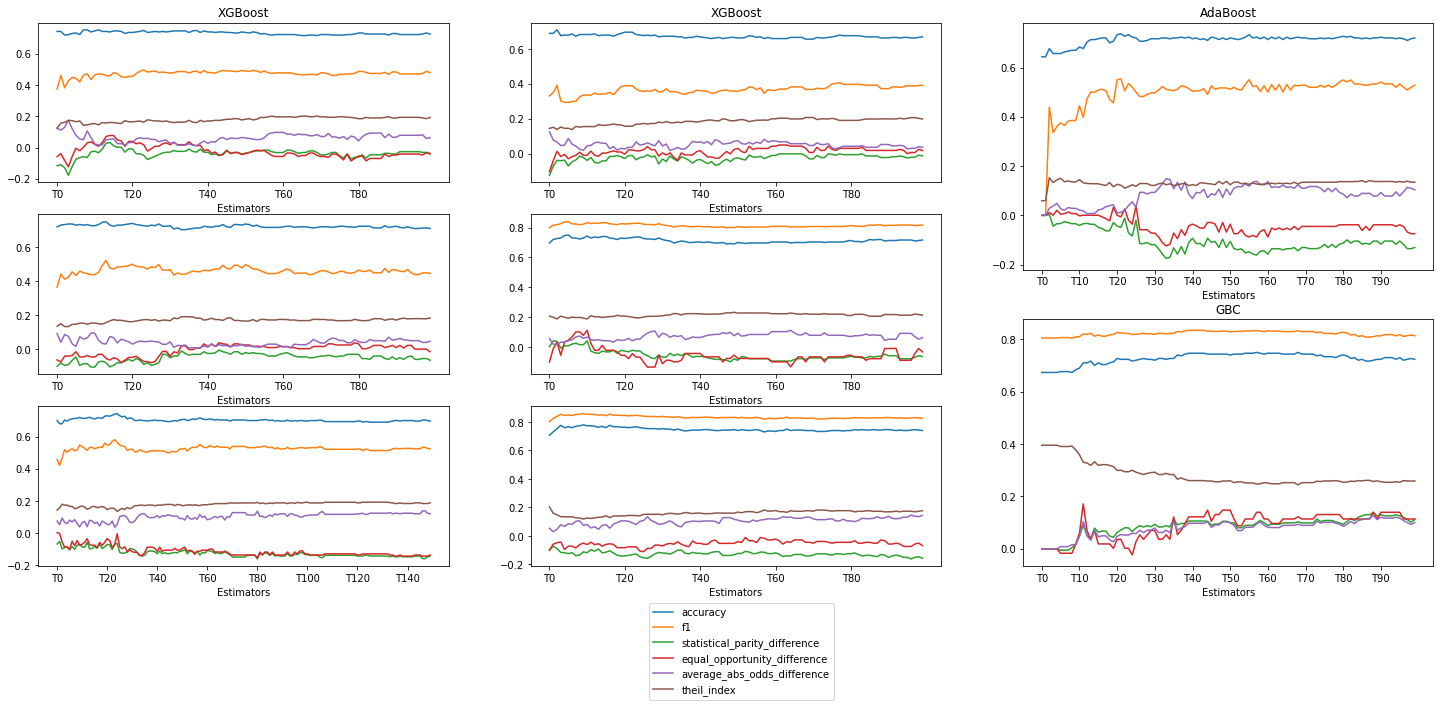

In [167]:
from matplotlib import gridspec

figure = plt.figure(figsize=(25,10))
ncols = 1
nrows = 0
'''
ax1= figure.add_subplot(3,3,1)
ax2= figure.add_subplot(3,3,2)
ax3= figure.add_subplot(3,3,4)
ax4= figure.add_subplot(3,3,5)
ax5= figure.add_subplot(3,3,7)
ax6= figure.add_subplot(3,3,8)

ax7= figure.add_subplot(2,3,3)
ax8= figure.add_subplot(2,3,6)
'''
#for df in GC_dict.keys():
#print(model)  
#model = model.transpose()
#model = model.set_index(model.columns)
#print(model)
#ax7= figure.add_subplot(2,3,3)
#ax7.set_xticks(np.arange(model.shape[0])[::10])
#ax7.plot(model)

for df in GC_dict.keys():
    print(df)
    if df.split("\\")[2] == 'XGBoost':

        if (ncols == 3 or ncols == 6):
            ncols = ncols + 1
        
        model = GC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        model = model.transpose()
        ax1= figure.add_subplot(3,3,ncols)
        ax1.set_xticks(np.arange(model.shape[0])[::20])
        plt.xlabel("Estimators")
        if ncols == 1 or ncols == 2:
            plt.title("XGBoost")
        ax1.plot(model)
        ncols = ncols+1
        if ncols == 7:
            ncols = 0
 
    if df.split("\\")[2] == 'AdaBoost':
        model = GC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        model = model.transpose()
        ax1= figure.add_subplot(2,3,3)
        ax1.set_xticks(np.arange(model.shape[0])[::10])
        plt.title("AdaBoost")
        plt.xlabel("Estimators")
        ax1.plot(model)
            
    if df.split("\\")[2] == 'GBC':
        model = GC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
        model = model.transpose()
        ax1= figure.add_subplot(2,3,6)
        ax1.set_xticks(np.arange(model.shape[0])[::10])
        plt.title("GBC")
        plt.xlabel("Estimators")
        ax1.plot(model)

            
plt.savefig('GermanCredit_Boosting_Estimators.pdf', bbox_inches='tight')
plt.tight_layout()
plt.legend(['accuracy', 'f1', 'statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference', 'theil_index'], loc='best', bbox_to_anchor=(0.75, -0.2))
plt.savefig('GermanCredit_Boosting_Estimators.pdf', bbox_inches='tight')
plt.show()


##### GBC

GermanCredit\Results\AdaBoost\0-predicting-credit-risk-model-pipeline.csv
GermanCredit\Results\GBC\3-bank-credit-data-clustering-modelling.csv
GermanCredit\Results\LGBM\1-credit-risk-evaluation.csv
GermanCredit\Results\LGBM\4-predicting-credit-risk.csv
GermanCredit\Results\XGBoost\0-predicting-credit-risk-model-pipeline.csv
GermanCredit\Results\XGBoost\1-credit-risk-evaluation.csv
GermanCredit\Results\XGBoost\10-credit-risk-assessment.csv
GermanCredit\Results\XGBoost\3-bank-credit-data-clustering-modelling.csv
GermanCredit\Results\XGBoost\6-credit-risk-modelling-german-data.csv
GermanCredit\Results\XGBoost\7-predicting-credit-risk-model-pipeline-60deb1.csv


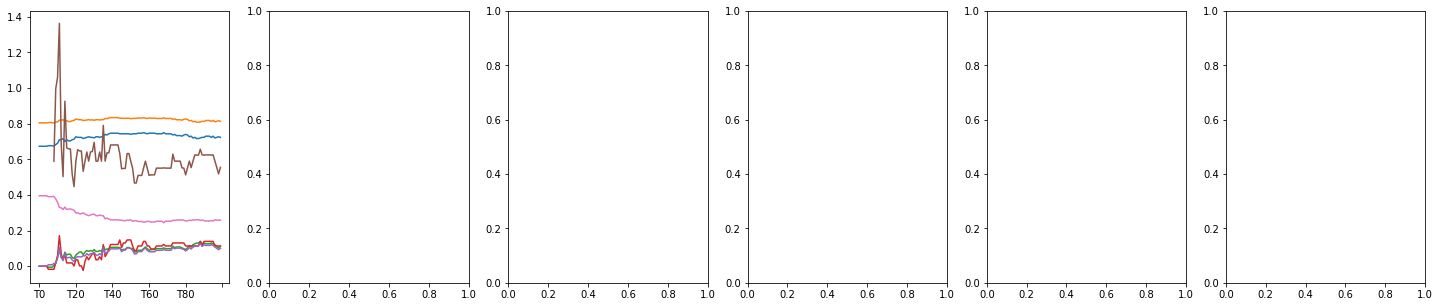

In [153]:
figure, axis = plt.subplots(1, 6, figsize=(25,5))
ncols = 0
nrows = 0

for df in GC_dict.keys():
    print(df)
    if ncols >= 6:
        break
    if df.split("\\")[2] == 'GBC':
        model = GC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        temp = model.T.plot(ax=axis[ncols], legend=0)
        ncols = ncols+1

##### LGBM

GermanCredit\Results\AdaBoost\0-predicting-credit-risk-model-pipeline.csv
GermanCredit\Results\GBC\3-bank-credit-data-clustering-modelling.csv
GermanCredit\Results\LGBM\1-credit-risk-evaluation.csv
GermanCredit\Results\LGBM\4-predicting-credit-risk.csv
GermanCredit\Results\XGBoost\0-predicting-credit-risk-model-pipeline.csv
GermanCredit\Results\XGBoost\1-credit-risk-evaluation.csv
GermanCredit\Results\XGBoost\10-credit-risk-assessment.csv
GermanCredit\Results\XGBoost\3-bank-credit-data-clustering-modelling.csv
GermanCredit\Results\XGBoost\6-credit-risk-modelling-german-data.csv
GermanCredit\Results\XGBoost\7-predicting-credit-risk-model-pipeline-60deb1.csv


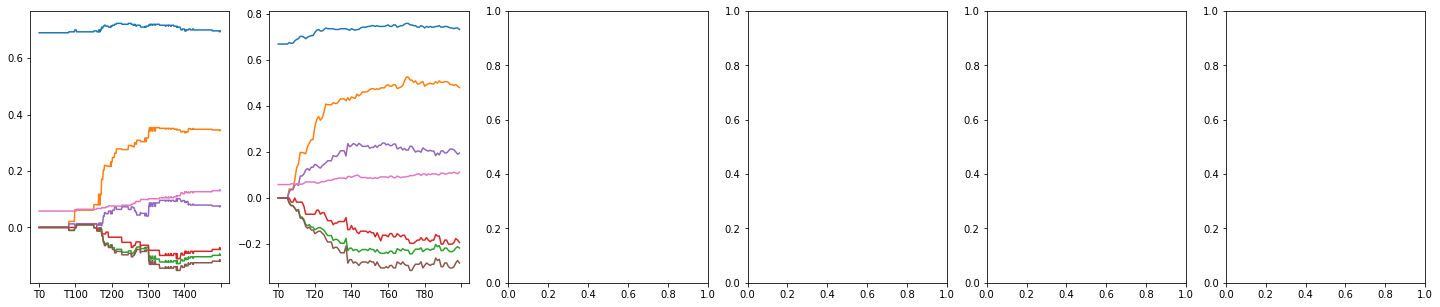

In [154]:
figure, axis = plt.subplots(1, 6, figsize=(25,5))
ncols = 0
nrows = 0

for df in GC_dict.keys():
    print(df)
    if ncols >= 6:
        break
    if df.split("\\")[2] == 'LGBM':
        model = GC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        temp = model.T.plot(ax=axis[ncols], legend=0)
        ncols = ncols+1

#### AdaBoost

GermanCredit\Results\AdaBoost\0-predicting-credit-risk-model-pipeline.csv
GermanCredit\Results\GBC\3-bank-credit-data-clustering-modelling.csv
GermanCredit\Results\LGBM\1-credit-risk-evaluation.csv
GermanCredit\Results\LGBM\4-predicting-credit-risk.csv
GermanCredit\Results\XGBoost\0-predicting-credit-risk-model-pipeline.csv
GermanCredit\Results\XGBoost\1-credit-risk-evaluation.csv
GermanCredit\Results\XGBoost\10-credit-risk-assessment.csv
GermanCredit\Results\XGBoost\3-bank-credit-data-clustering-modelling.csv
GermanCredit\Results\XGBoost\6-credit-risk-modelling-german-data.csv
GermanCredit\Results\XGBoost\7-predicting-credit-risk-model-pipeline-60deb1.csv


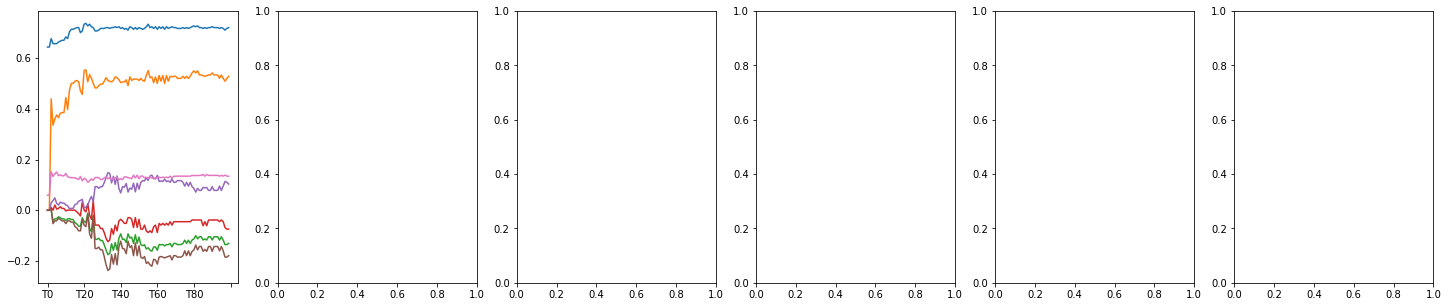

In [155]:
figure, axis = plt.subplots(1, 6, figsize=(25,5))
ncols = 0
nrows = 0

for df in GC_dict.keys():
    print(df)
    if ncols >= 6:
        break
    if df.split("\\")[2] == 'AdaBoost':
        model = GC_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        temp = model.T.plot(ax=axis[ncols], legend=0)
        ncols = ncols+1

,accuracy,f1,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
T0,0.813433,0.739583,-0.833222,-0.721945,0.732451,-3.072345,0.148699
classifier,0.828358,0.757895,-0.632796,-0.504316,0.415010,-1.957538,0.140978
difference,0.014925,0.018311,0.200426,0.217628,-0.317441,1.114807,-0.007720


,accuracy,f1,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
T0,0.820896,0.696203,-0.565735,-0.561316,0.387325,-2.269504,0.168110
classifier,0.787313,0.691892,-0.627070,-0.482054,0.474360,-1.662669,0.149118
difference,-0.033582,-0.004311,-0.061335,0.079262,0.087036,0.606835,-0.018993


,accuracy,f1,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
T0,0.842697,0.769231,-0.697355,-0.457386,0.476952,-2.095378,0.130571
classifier,0.823970,0.751323,-0.624345,-0.333333,0.395188,-1.659141,0.133205
difference,-0.018727,-0.017908,0.073009,0.124053,-0.081763,0.436237,0.002634


,accuracy,f1,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
T0,0.787313,0.704663,-1.000000,-1.000000,1.000000,-inf,0.162619
classifier,0.802239,0.730964,-0.795208,-0.653743,0.680893,-2.335094,0.145339
difference,0.014925,0.026301,0.204792,0.346257,-0.319107,inf,-0.017280


,accuracy,f1,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
T0,0.786047,0.697368,-0.666181,-0.616796,0.504827,-2.353885,0.202240
classifier,0.781395,0.708075,-0.603244,-0.438265,0.433418,-1.712031,0.187393
difference,-0.004651,0.010706,0.062937,0.178532,-0.071409,0.641854,-0.014847


,accuracy,f1,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
T0,0.801498,0.736318,-0.776367,-0.806693,0.681183,-2.608388,0.145893
classifier,0.850187,0.809524,-0.673721,-0.486513,0.420778,-1.785245,0.097670
difference,0.048689,0.073205,0.102646,0.320180,-0.260405,0.823143,-0.048223


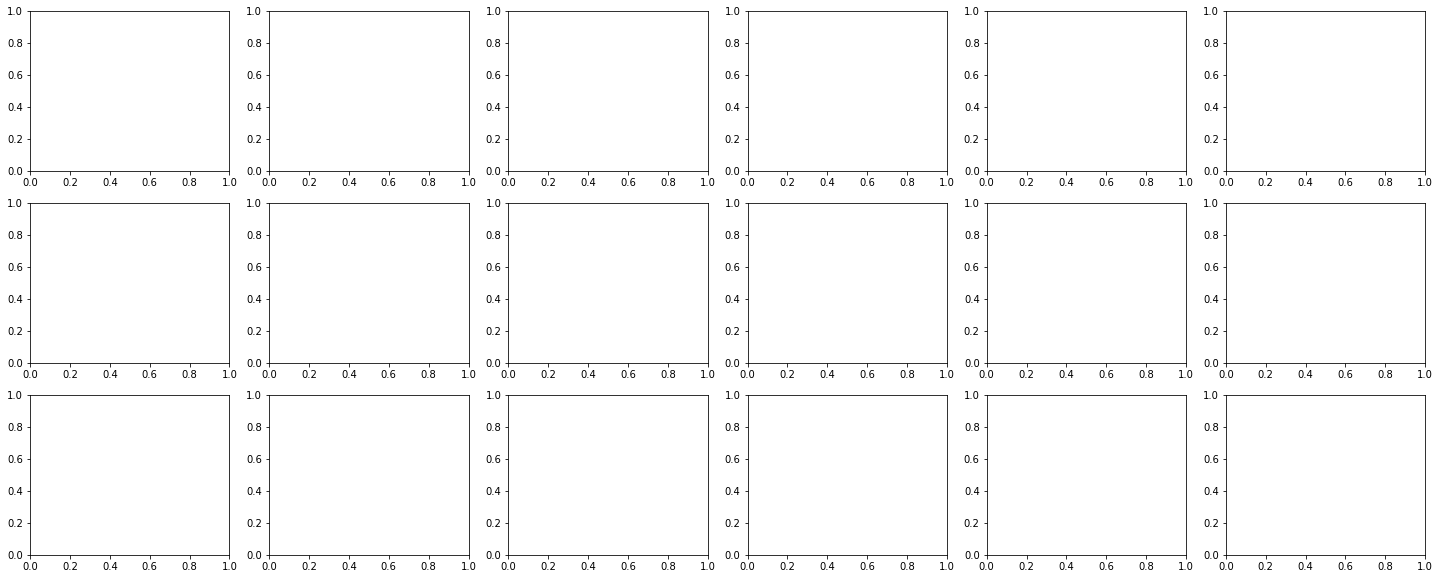

dict_keys(['TM_XGB1', 'TM_XGB2', 'TM_XGB3', 'TM_XGB4', 'TM_XGB5', 'TM_XGB6'])


In [42]:
figure, axis = plt.subplots(3, 6, figsize=(25,10))
ncols = 0

TM_df = {}

for df in TM_dict.keys():
    model_new = pd.DataFrame()
    #print(df)
    
    if df.split("\\")[2] == 'XGBoost':
        ncols = ncols + 1
        model = TM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        #model = model.drop(["classifier"], axis = 1)
        #model= model.drop('disparate_impact')
        model_new['T0'] = model['T0']
        model_new['classifier'] = model['classifier']
        model_new['difference'] = model['classifier'] - model['T0']
        display(model_new.T)
        TM_df['TM_XGB' + str(ncols)] = model_new
        if ncols == 6:
            ncols = 0
        
        
            
    if df.split("\\")[2] == 'AdaBoost':
        model = TM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')
       
            
    if df.split("\\")[2] == 'GBC':
        model = TM_dict[df].set_index('Unnamed: 0')
        model.index.name = None
        model = model.drop(["classifier"], axis = 1)
        model= model.drop('disparate_impact')

#plt.legend(handles=[l, l2, l3, l4],loc="upper left", bbox_to_anchor=[0, 1],
#ncol=2, shadow=True, title="Legend", fancybox=True)
#handles, labels = temp.get_legend_handles_labels()
#temp.legend(handles, labels, loc='upper center')
temp.legend(loc='best', bbox_to_anchor=(-2, -2.6))
plt.savefig('Titanic_Boosting_Estimators.pdf', bbox_inches='tight')
plt.show()

print(TM_df.keys())